a Sanford Health dataset that represents the ED (Emergency Department) volumes presenting to 4 Sanford Health medical centers 1/1/18 through 8/31/2025.
The dataset provides the facility, date, hour, reason, number of total encounters, number of those encounters admitted to a floor.

Forecast the future daily volumes (number of total encounters and the number of encounters admitted to a floor) for the month of September and October CY2025 (where CY means calendar year), by day.

# Basic things

In [104]:
# pip install polars

In [105]:
import polars as pl

df = pl.read_csv("DSU-Dataset.csv")

In [106]:
df.head()

Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
str,str,f64,str,i64,i64
"""A""","""2018-01-01""",0.0,"""BREATHING PROBLEM""",1,1
"""A""","""2018-01-01""",0.0,"""BURN""",1,0
"""A""","""2018-01-01""",0.0,"""SHAKING""",1,1
"""A""","""2018-01-01""",0.0,"""VOMITING""",1,0
"""A""","""2018-01-01""",1.0,"""FROSTBITE""",1,0


In [107]:
col = df["Date"].str.to_date()
df = df.with_columns(col)

In [108]:
df.describe()

statistic,Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
str,str,str,f64,str,f64,f64
"""count""","""1174310""","""1174310""",1.17431e6,"""1168105""",1.17431e6,1.17431e6
"""null_count""","""0""","""0""",0.0,"""6205""",0.0,0.0
"""mean""",null,"""2021-12-05 23:13:59.314320""",13.549324,null,1.084646,0.291522
"""std""",null,null,6.142173,null,0.322814,0.47727
"""min""","""A""","""2018-01-01""",0.0,"""ABDOMINAL AORTIC ANEURYSM""",1.0,0.0
"""25%""",null,"""2019-12-23""",10.0,null,1.0,0.0
"""50%""",null,"""2021-12-30""",14.0,null,1.0,0.0
"""75%""",null,"""2023-11-11""",19.0,null,1.0,1.0
"""max""","""D""","""2025-08-31""",23.0,"""WRIST PAIN""",8.0,5.0


The forecasted volumes are not to be broken down by reason of visit.

In [109]:
import numpy as np

columns = df.columns

for col in columns:
    print(f"Column {col} has {df[col].is_null().sum()} missing values.")

print(f"ED Enc has a min of {df['ED Enc'].min()} and a max of {df['ED Enc'].max()} at a particular hour for a certain reason")
print(f"ED Enc Admitted has a min of {df['ED Enc Admitted'].min()} and a max of {df['ED Enc Admitted'].max()} at a particular hour for a certain reason")
print(f"There are sites: {', '.join([site for site in df['Site'].unique()])}")

Column Site has 0 missing values.
Column Date has 0 missing values.
Column Hour has 0 missing values.
Column REASON_VISIT_NAME has 6205 missing values.
Column ED Enc has 0 missing values.
Column ED Enc Admitted has 0 missing values.
ED Enc has a min of 1 and a max of 8 at a particular hour for a certain reason
ED Enc Admitted has a min of 0 and a max of 5 at a particular hour for a certain reason
There are sites: B, D, C, A


A site can tell us how many encounters/admissions to ED.

In [110]:
# normalize values

site_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
reason_dict = {reason: idx for idx, reason in enumerate(df['REASON_VISIT_NAME'].unique())}

df_friendly = df.with_columns(
    [pl.col("Date").dt.year().alias("Year").cast(pl.Int32),
     pl.col("Date").dt.month().alias("Month").cast(pl.Int32),
     pl.col("Date").dt.day().alias("Day").cast(pl.Int32)]).drop("Date")

df_friendly = df_friendly.select(["Site", "Year", "Month", "Day", "Hour", "REASON_VISIT_NAME", "ED Enc", "ED Enc Admitted"])
df_friendly = df_friendly.with_columns(
    pl.col('Site').replace(site_dict).cast(pl.Int32),
    pl.col('REASON_VISIT_NAME').replace(reason_dict).cast(pl.Int32)
)

df_friendly.head()

Site,Year,Month,Day,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
i32,i32,i32,i32,f64,i32,i64,i64
0,2018,1,1,0.0,848,1,1
0,2018,1,1,0.0,669,1,0
0,2018,1,1,0.0,218,1,1
0,2018,1,1,0.0,157,1,0
0,2018,1,1,1.0,638,1,0


A heatmap without covid years but has year, month, day, hour, and reason visit.

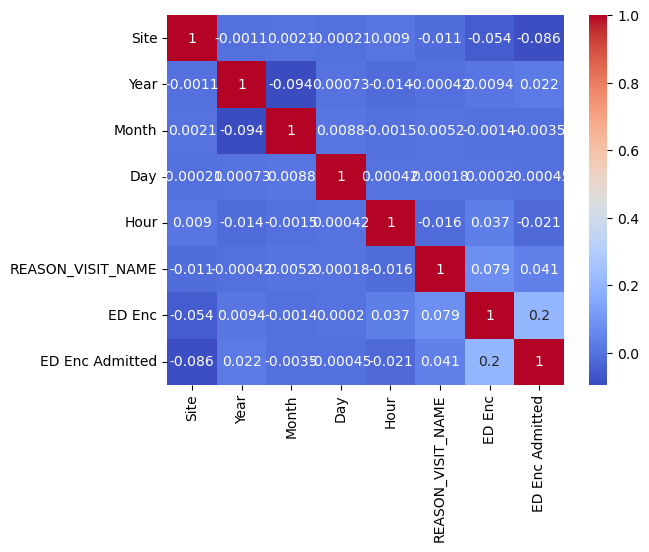

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

df_friendly_normal = df_friendly.filter((pl.col('Year') != 2020) & (pl.col('Year') != 2021))

ax = sns.heatmap(df_friendly_normal.corr(), annot=True, cmap='coolwarm', xticklabels=df_friendly_normal.columns, yticklabels=df_friendly_normal.columns)

# Trends in months

Combine encounters by months, then facilities. See trends over months

In [112]:
start_date = df["Date"].min()
end_date = df["Date"].max()
month_date_range = pl.date_range(start=start_date, end=end_date, interval="1mo",  eager=True)

reverse_site_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}

monthly_site_data = df_friendly.group_by(["Year", "Month", "Site"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
monthly_site_data = monthly_site_data.with_columns(
    monthly_site_data["Site"].replace_strict(reverse_site_dict)
)
print(monthly_site_data.head())

monthly_data = df_friendly.group_by(["Year", "Month"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
print(monthly_data.head())

shape: (5, 5)
┌──────┬───────┬──────┬────────┬─────────────────┐
│ Year ┆ Month ┆ Site ┆ ED Enc ┆ ED Enc Admitted │
│ ---  ┆ ---   ┆ ---  ┆ ---    ┆ ---             │
│ i32  ┆ i32   ┆ str  ┆ i64    ┆ i64             │
╞══════╪═══════╪══════╪════════╪═════════════════╡
│ 2024 ┆ 9     ┆ B    ┆ 5481   ┆ 1502            │
│ 2019 ┆ 2     ┆ C    ┆ 2528   ┆ 748             │
│ 2020 ┆ 3     ┆ A    ┆ 3223   ┆ 987             │
│ 2024 ┆ 10    ┆ D    ┆ 2229   ┆ 414             │
│ 2022 ┆ 4     ┆ A    ┆ 3525   ┆ 1054            │
└──────┴───────┴──────┴────────┴─────────────────┘
shape: (5, 4)
┌──────┬───────┬────────┬─────────────────┐
│ Year ┆ Month ┆ ED Enc ┆ ED Enc Admitted │
│ ---  ┆ ---   ┆ ---    ┆ ---             │
│ i32  ┆ i32   ┆ i64    ┆ i64             │
╞══════╪═══════╪════════╪═════════════════╡
│ 2023 ┆ 12    ┆ 15126  ┆ 4166            │
│ 2025 ┆ 3     ┆ 14974  ┆ 4188            │
│ 2025 ┆ 7     ┆ 15390  ┆ 4185            │
│ 2022 ┆ 9     ┆ 14575  ┆ 3758            │
│ 2023 ┆ 9     

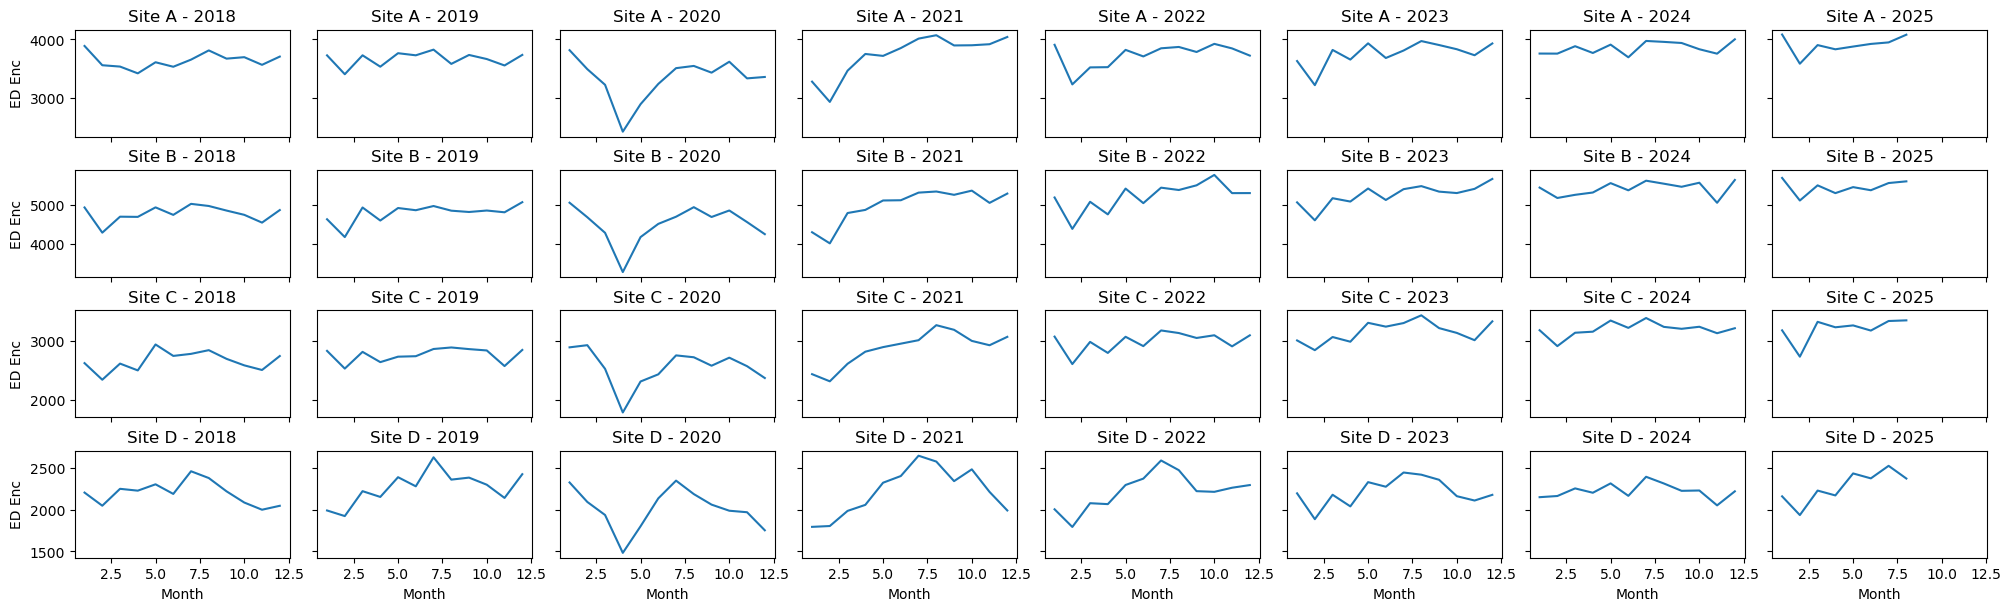

In [113]:
# for each year (2018-2025), create a line plot of monthly ED Enc for each site
# 8 years, 4 sites
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=True, sharey="row")

for i, year in enumerate(range(2018, 2026)):
    for j, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=monthly_site_data.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Month', y='ED Enc', ax=axes[j, i])
        axes[j, i].set_title(f'Site {site} - {year}')
        axes[j, i].set_xlabel('Month')
        axes[j, i].set_ylabel('ED Enc')

plt.show()


In [123]:
daily_site_data = df_friendly.group_by(["Year", "Month", "Day", "Site"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
daily_data = df_friendly.group_by(["Year", "Month", "Day"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

daily_site_data = daily_site_data.with_columns(
    daily_site_data["Site"].replace_strict(reverse_site_dict),
    (pl.col("Month") + (pl.col("Day") - 1) / 30).alias("Month")
).drop("Day")

daily_data = daily_data.with_columns(
    (pl.col("Month") + (pl.col("Day") - 1) / 30).alias("Month")
).drop("Day")

print(daily_site_data.head())
print(daily_site_data.shape)
print(daily_data.shape)

shape: (5, 5)
┌──────┬──────────┬──────┬────────┬─────────────────┐
│ Year ┆ Month    ┆ Site ┆ ED Enc ┆ ED Enc Admitted │
│ ---  ┆ ---      ┆ ---  ┆ ---    ┆ ---             │
│ i32  ┆ f64      ┆ str  ┆ i64    ┆ i64             │
╞══════╪══════════╪══════╪════════╪═════════════════╡
│ 2019 ┆ 4.1      ┆ C    ┆ 73     ┆ 22              │
│ 2018 ┆ 6.733333 ┆ A    ┆ 110    ┆ 32              │
│ 2025 ┆ 1.166667 ┆ C    ┆ 117    ┆ 38              │
│ 2019 ┆ 7.466667 ┆ D    ┆ 66     ┆ 7               │
│ 2022 ┆ 13.0     ┆ D    ┆ 79     ┆ 8               │
└──────┴──────────┴──────┴────────┴─────────────────┘
(11200, 5)
(2800, 4)


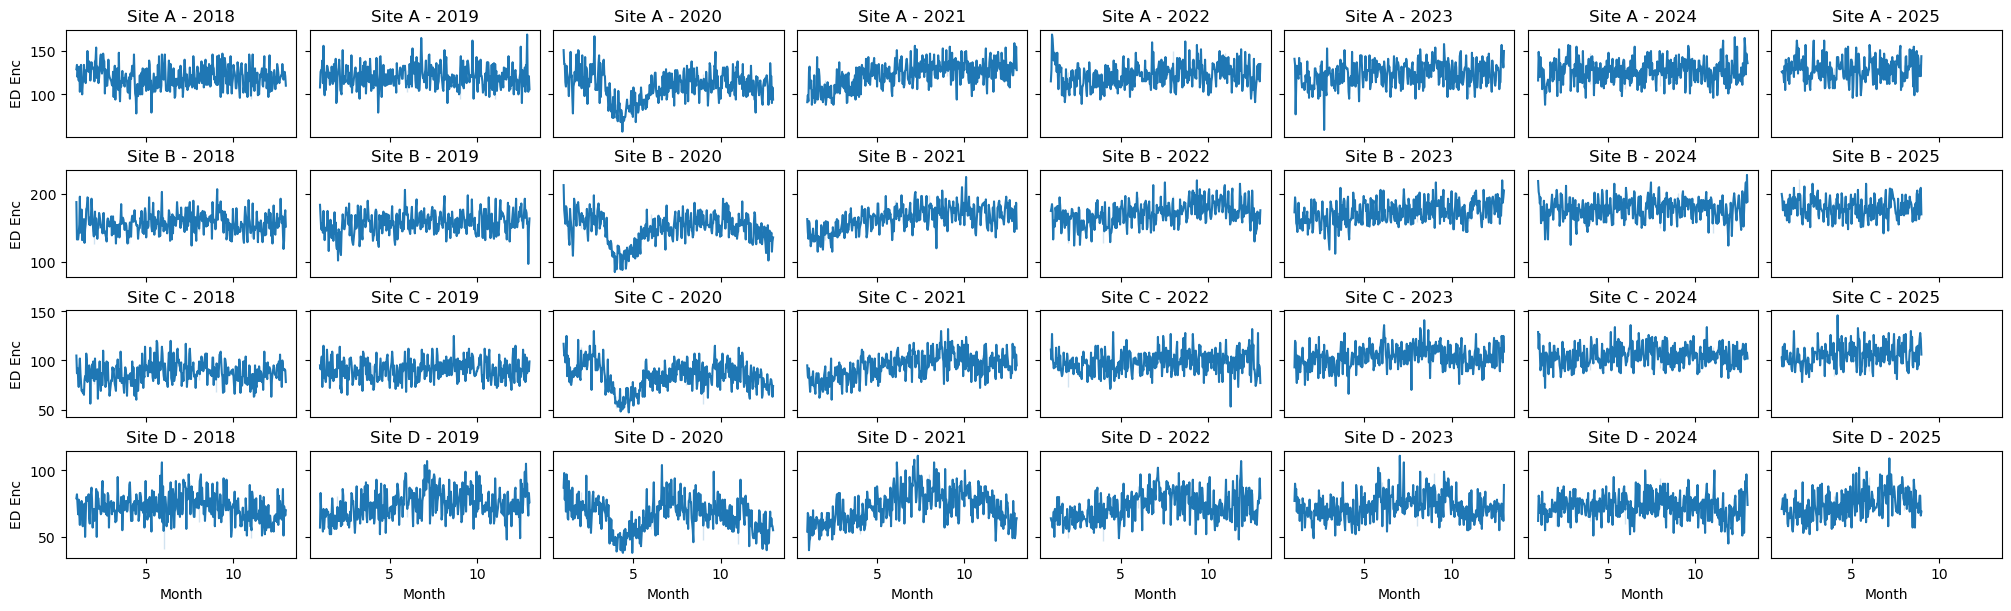

In [ ]:
# same thing but with days
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=True, sharey="row")

for i, year in enumerate(range(2018, 2026)):
    for j, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=daily_site_data.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Month', y='ED Enc', ax=axes[j, i])
        axes[j, i].set_title(f'Site {site} - {year}')
        axes[j, i].set_xlabel('Month')
        axes[j, i].set_ylabel('ED Enc')

plt.show()


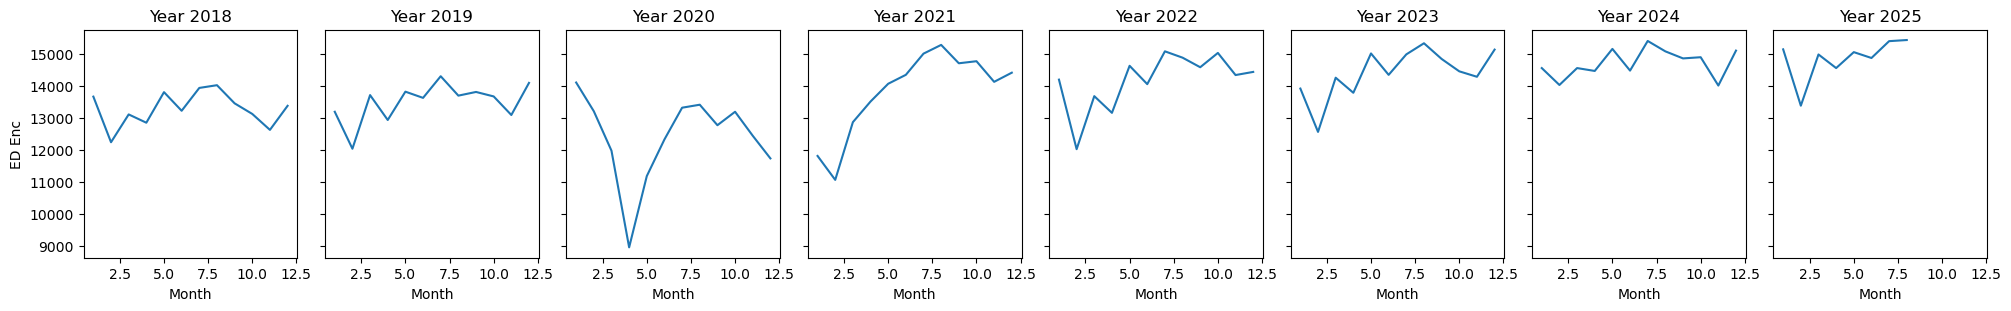

In [116]:
fig, axes = plt.subplots(1, 8, layout="constrained", figsize=(20, 3), sharex=True, sharey=True)

for i, year in enumerate(range(2018, 2026)):
    sns.lineplot(data=monthly_data.filter(pl.col('Year') == year),
                    x='Month', y='ED Enc', ax=axes[i])
    axes[i].set_title(f'Year {year}')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('ED Enc')

plt.show()

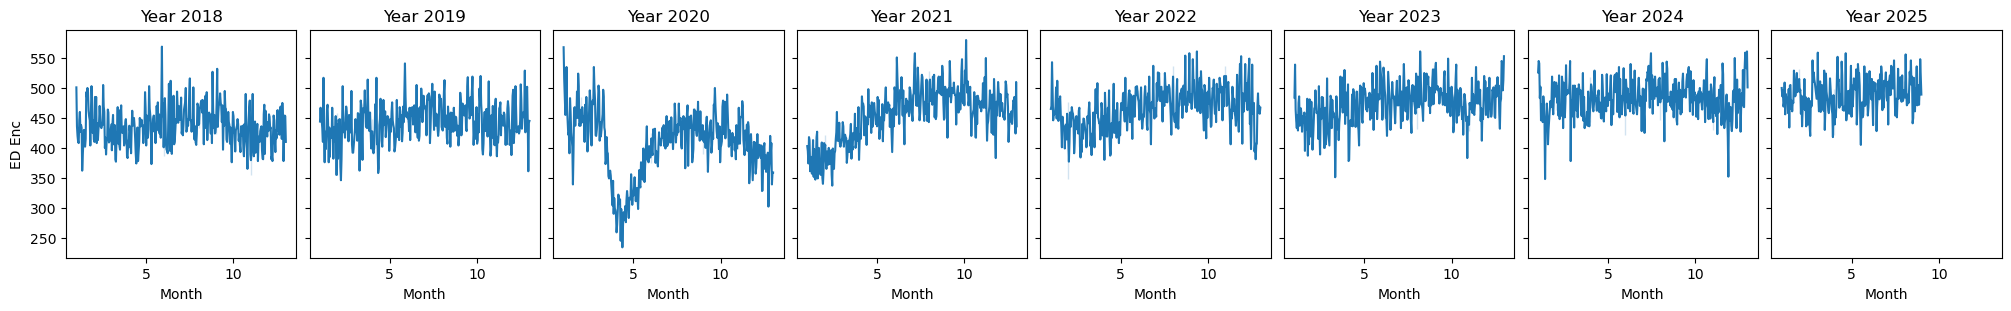

In [124]:
fig, axes = plt.subplots(1, 8, layout="constrained", figsize=(20, 3), sharex=True, sharey=True)

for i, year in enumerate(range(2018, 2026)):
    sns.lineplot(data=daily_data.filter(pl.col('Year') == year),
                    x='Month', y='ED Enc', ax=axes[i])
    axes[i].set_title(f'Year {year}')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('ED Enc')

plt.show()

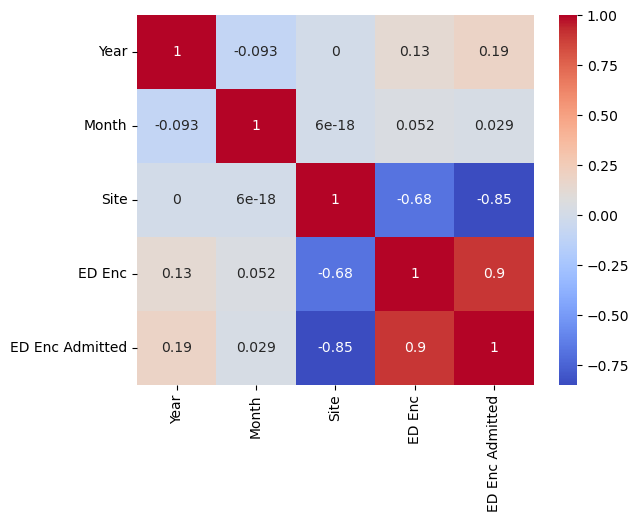

In [ ]:
# let us drop 2020 and 2021 to see the trend without covid years
monthly_site_data_normal = monthly_site_data.filter((pl.col('Year') != 2020) & (pl.col('Year') != 2021))
monthly_site_data_normal = monthly_site_data_normal.with_columns(
    pl.col('Site').replace(site_dict).cast(pl.Int32)
)

ax = sns.heatmap(monthly_site_data_normal.corr(), annot=True, cmap='coolwarm', xticklabels=monthly_site_data_normal.columns, yticklabels=monthly_site_data_normal.columns)